# Group 5: Nishal Dave, Mollie Li, Wei Dai, Ajiboye Olaoye

In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import accuracy_score

from itertools import combinations
from itertools import combinations_with_replacement

!pip install glmnet
import glmnet as gln

import pydot
from IPython.display import Image
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report



# $Question\;(1)$

# $(a)$

In [122]:
df = pd.read_csv("Credit.csv")
df

,ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331
...,...,...,...,...,...,...,...,...,...,...,...,...
395,396,12.096,4100,307,3,32,13,Male,No,Yes,Caucasian,560
396,397,13.364,3838,296,5,65,17,Male,No,No,African American,480
397,398,57.872,4171,321,5,67,12,Female,No,Yes,Caucasian,138
398,399,37.728,2525,192,1,44,13,Male,No,Yes,Caucasian,0


In [123]:
df.isna().any()
#Yields no missing observations

ID           False
Income       False
Limit        False
Rating       False
Cards        False
Age          False
Education    False
Gender       False
Student      False
Married      False
Ethnicity    False
Balance      False
dtype: bool

In [124]:
#Create dummies for:
  #cards, student, married, ethnicity

df.drop("ID",axis=1,inplace=True)
df.dropna()

#Dummy for Cards
#df.loc[:,"Cards:2"] = [1 if x==2 else 0 for x in df["Cards"]]
#df.loc[:,"Cards:3"] = [1 if x==3 else 0 for x in df["Cards"]]
#df.loc[:,"Cards:4"] = [1 if x==4 else 0 for x in df["Cards"]]
#df.loc[:,"Cards:5"] = [1 if x==5 else 0 for x in df["Cards"]]
#df.loc[:,"Cards:6"] = [1 if x==6 else 0 for x in df["Cards"]]
#df.loc[:,"Cards:7"] = [1 if x==7 else 0 for x in df["Cards"]]
#df.loc[:,"Cards:8"] = [1 if x==8 else 0 for x in df["Cards"]]
#df.loc[:,"Cards:9"] = [1 if x==9 else 0 for x in df["Cards"]]
#df.drop(columns="Cards",inplace=True)

#Dummy for Student
df.loc[:,"Student"] = [1 if x=="Yes" else 0 for x in df["Student"]]

#Dummy for Married
df.loc[:,"Married"] = [1 if x=="Yes" else 0 for x in df["Married"]]

#Dummy for Ethnicity
df.loc[:,"Asian"] = [1 if x=="Asian" else 0 for x in df["Ethnicity"]]
df.loc[:,"African American"] = [1 if x=="African American" else 0 for x in df["Ethnicity"]]
df.drop(columns="Ethnicity",inplace=True)

#Dummy for Gender
df.loc[:,"Male"] = [1 if x=="Male" else 0 for x in df["Gender"]]
df.drop(columns="Gender",inplace=True)

VartoStdze = ["Income","Limit","Rating","Age","Education","Cards"]
scale = StandardScaler()
for i in VartoStdze:
    df[i]=scale.fit_transform(df[i].values.reshape(-1,1))

In [125]:
df

,Income,Limit,Rating,Cards,Age,Education,Student,Married,Balance,Asian,African American,Male
0,-0.861583,-0.489999,-0.465539,-0.699130,-1.257674,-0.784930,0,1,333,0,0,0
1,1.727437,0.828261,0.828703,0.031032,1.528451,0.496588,1,1,903,1,0,0
2,1.686756,1.014787,1.029311,0.761194,0.889964,-0.784930,0,0,580,1,0,0
3,2.946152,2.068440,2.110003,0.031032,-1.141586,-0.784930,0,0,964,1,0,0
4,0.302928,0.070012,0.013331,-0.699130,0.715831,0.816968,0,1,331,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.940986,-0.275711,-0.310230,0.031032,-1.373763,-0.144171,0,1,560,0,0,0
396,-0.904963,-0.389362,-0.381413,1.491355,0.541698,1.137347,0,0,480,0,1,0
397,0.359462,-0.244913,-0.219633,1.491355,0.657787,-0.464550,0,1,138,0,0,0
398,-0.212808,-0.958916,-1.054419,-1.429291,-0.677231,-0.144171,0,1,0,0,0,0


There are 400 observations in total $(n=400)$ with $J=12$ columns of  explanatory variables. Based on the non-linear regression above, this would yield $2\times(12)+\frac{12!}{2!(12-2)!}$ number of predictors, which is equal to $p=90$ predictors in total.

An OLS can be used for this, however with so many predictors and it is likely that a reasonable amount of them do not play a large role in the prediction of an individual's credit score, another thing to consider is that given that there are a lot of predictors in comparison to the overall sample size, although it is not an exact science, there would be around 4 observations per predictor, which is somewhat low. 

A shrinkage method such as the Lasso can identify these less relevant predictors and shrink their coefficient towards zero which is beneficial in identifying the important predictors, whereas the OLS does not penalise the less relevant predictors, by comparison the Lasso produces a far more succinct model. 

# $(b)$

In [126]:
#Dropping the dependent variable
df2 = df.drop('Balance',axis=1)

In [127]:
#Transforming the dataframe to conform to the non-linear regression function 
#Acquiring the pairwise combination across all regressors
df3 = df2.apply(lambda s:
                   pd.Series(
                       {i: c for i, c in enumerate(combinations_with_replacement(s.values, 2))}
                   ),
                   axis=1)

#Multiplying each pair by one another for all observations across all rows
for k in range(0,66):
  for i in range(0,400):
    df3[k][i]=df3[k][i][0]*df3[k][i][1]

#Generating column names using the combination function again
combs = list(combinations_with_replacement(df2, 2))
colnames = {}
for i in range(0,66):
  colnames[i]=(combs[i][0]+'*'+combs[i][1])

#Applying the new column names to the new dataframe 
df3 = df3.rename(columns=dict(colnames))

In [128]:
#Merge df and add intercept
df4 = pd.concat([df2,df3],axis=1)
df4["intercept"] = 1

In [129]:
df4

,Income,Limit,Rating,Cards,Age,Education,Student,Married,Asian,African American,Male,Income*Income,Income*Limit,Income*Rating,Income*Cards,Income*Age,Income*Education,Income*Student,Income*Married,Income*Asian,Income*African American,Income*Male,Limit*Limit,Limit*Rating,Limit*Cards,Limit*Age,Limit*Education,Limit*Student,Limit*Married,Limit*Asian,Limit*African American,Limit*Male,Rating*Rating,Rating*Cards,Rating*Age,Rating*Education,Rating*Student,Rating*Married,Rating*Asian,Rating*African American,Rating*Male,Cards*Cards,Cards*Age,Cards*Education,Cards*Student,Cards*Married,Cards*Asian,Cards*African American,Cards*Male,Age*Age,Age*Education,Age*Student,Age*Married,Age*Asian,Age*African American,Age*Male,Education*Education,Education*Student,Education*Married,Education*Asian,Education*African American,Education*Male,Student*Student,Student*Married,Student*Asian,Student*African American,Student*Male,Married*Married,Married*Asian,Married*African American,Married*Male,Asian*Asian,Asian*African American,Asian*Male,African American*African American,African American*Male,Male*Male,intercept
0,-0.861583,-0.489999,-0.465539,-0.699130,-1.257674,-0.784930,0,1,0,0,0,0.742325,0.422175,0.4011,0.602358,1.08359,0.676282,-0,-0.861583,-0,-0,-0,0.240099,0.228113,0.342573,0.616259,0.384615,-0,-0.489999,-0,-0,-0,0.216726,0.325472,0.585496,0.365415,-0,-0.465539,-0,-0,-0,0.488782,0.879277,0.548768,-0,-0.69913,-0,-0,-0,1.58174,0.987186,-0,-1.25767,-0,-0,-0,0.616115,-0,-0.78493,-0,-0,-0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,1.727437,0.828261,0.828703,0.031032,1.528451,0.496588,1,1,1,0,0,2.98404,1.43077,1.43153,0.0536056,2.6403,0.857825,1.72744,1.72744,1.72744,0,0,0.686016,0.686383,0.0257025,1.26596,0.411305,0.828261,0.828261,0.828261,0,0,0.686749,0.0257162,1.26663,0.411524,0.828703,0.828703,0.828703,0,0,0.000962977,0.0474307,0.0154101,0.0310319,0.0310319,0.0310319,0,0,2.33616,0.759011,1.52845,1.52845,1.52845,0,0,0.2466,0.496588,0.496588,0.496588,0,0,1,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1
2,1.686756,1.014787,1.029311,0.761194,0.889964,-0.784930,0,0,1,0,0,2.84514,1.7117,1.7362,1.28395,1.50115,-1.32398,0,0,1.68676,0,0,1.02979,1.04453,0.772449,0.903123,-0.796537,0,0,1.01479,0,0,1.05948,0.783505,0.916049,-0.807937,0,0,1.02931,0,0,0.579416,0.677435,-0.597484,0,0,0.761194,0,0,0.792035,-0.698559,0,0,0.889964,0,0,0.616115,-0,-0,-0.78493,-0,-0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,2.946152,2.068440,2.110003,0.031032,-1.141586,-0.784930,0,0,1,0,0,8.67981,6.09394,6.21639,0.0914246,-3.36328,-2.31252,0,0,2.94615,0,0,4.27845,4.36441,0.0641876,-2.3613,-1.62358,0,0,2.06844,0,0,4.45211,0.0654773,-2.40875,-1.6562,0,0,2.11,0,0,0.000962977,-0.0354255,-0.0243578,0,0,0.0310319,0,0,1.30322,0.896065,-0,-0,-1.14159,-0,-0,0.616115,-0,-0,-0.78493,-0,-0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,0.302928,0.070012,0.013331,-0.699130,0.715831,0.816968,0,1,0,0,0,0.0917652,0.0212086,0.00403824,-0.211786,0.216845,0.247482,0,0.302928,0,0,0,0.00490171,0.000933311,-0.0489476,0.0501169,0.0571977,0,0.0700122,0,0,0,0.000177707,-0.00931988,0.00954252,0.0108907,0,0.0133307,0,0,0,0.488782,-0.500459,-0.571167,-0,-0.69913,-0,-0,-0,0.512414,0.584811,0,0.715831,0,0,0,0.667436,0,0.816968,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.940986,-0.275711,-0.310230,0.031032,-1.373763,-0.144171,0,1,0,0,0,0.885455,0.25944,0.291922,-0.0292006,1.29269,0.135663,-0,-0.940986,-0,-0,-0,0.0760166,0.0855338,-0.00855583,0.378762,0.0397495,-0,-0.275711,-0,-0,-0,0.0962425,-0.00962701,0.426182,0.0447261,-0,-0.31023,-0,-0,-0,0.000962977,-0.0426304,-0.00447389,0,0.0310319,0,0,0,1.88722,0.198056,-0,-1.37376,-0,-0,-0,0.0207852,-0,-0.144171,-0,-0,-0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
396,-0.904963,-0.389362,-0.381413,1.491355,0.541698,1.1

In [130]:
X = df4
y = df["Balance"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

clf = Lasso(alpha=0.5,fit_intercept=False,normalize=False,max_iter=5000)
lassomodel = clf.fit(X_train,y_train)

In [131]:
colnameslist = df4.columns.tolist()
coefficientlist = lassomodel.coef_.tolist()

dictionary = dict(zip(colnameslist, coefficientlist))
output = pd.DataFrame.from_dict(dictionary,orient='index')
output = output.rename(columns={0:"Coef"})
pd.set_option('display.max_rows', 200)
output

,Coef
Income,-279.512419
Limit,568.544133
Rating,35.917929
Cards,19.494562
Age,-11.018457
Education,-1.508624
Student,375.795007
Married,-0.000000
Asian,4.784912
African American,-0.000000


In [132]:
pd.set_option('display.max_rows', 25)


variables like student, income, and rating may have a better explanation when it comes to credit card
debt. Students are most likely to be vulnerable to credit debt because of their spending habits and lack of income, we
can also see that people with more education are more likely to have less debt may be due to higher
incomes facilitated by their extra qualifications. Also, an indication with age, whereby as people grow older they tend to spend less which
could lower their credit debt. 


# $(c)$

In [133]:
#Training inputs being used to predict outputs
ypred = clf.predict(X_train)

In [134]:
mean_squared_error(y_train, ypred)

2275.343346090848

# $(d)$

In [135]:
#Making cross-validation predictions
clfcv = LassoCV(cv=KFold(5), random_state=0, max_iter=100000)
abs(cross_val_score(clfcv, X, y, scoring='neg_mean_squared_error').mean())

3874.9378056555565

# $(e)$

We estimate the training MSE to be 2275 while the 5-fold CV gives us an estimation of 2737.
The discrepancy could occur here due to a difference in the two methods. The Training MSE is
estimated through the average of all the squared differences between the dependent variable and
the predicted variables. We expect the training MSE to be small because the data used is the same
data that was used to train the model so the predicted variables are close to the true responses, which causes overfitting.
Compared to Using the 5-fold CV which holds out each fold for testing purposes and reduces this overfitting problem. To compute the 5-fold CV we randomly split the data sample into 5 folds, the first fold
out of the 5 is the validation set. The 5-fold CV MSE is derived from an average MSE which is
calculated on each fold, so we take the average of the 5 MSE’s.

# $(f)$

$i.$

For $\lambda$, we will use 100 values between 0 and 0.5, with equal intervals this increments in steps of 0.005.

In [136]:
#List of lambda values from 0.01 to 0.99
lambdalist = (np.array(list(range(1,10000,100))))/1000
(lambdalist) 

array([1.000e-03, 1.010e-01, 2.010e-01, 3.010e-01, 4.010e-01, 5.010e-01,
       6.010e-01, 7.010e-01, 8.010e-01, 9.010e-01, 1.001e+00, 1.101e+00,
       1.201e+00, 1.301e+00, 1.401e+00, 1.501e+00, 1.601e+00, 1.701e+00,
       1.801e+00, 1.901e+00, 2.001e+00, 2.101e+00, 2.201e+00, 2.301e+00,
       2.401e+00, 2.501e+00, 2.601e+00, 2.701e+00, 2.801e+00, 2.901e+00,
       3.001e+00, 3.101e+00, 3.201e+00, 3.301e+00, 3.401e+00, 3.501e+00,
       3.601e+00, 3.701e+00, 3.801e+00, 3.901e+00, 4.001e+00, 4.101e+00,
       4.201e+00, 4.301e+00, 4.401e+00, 4.501e+00, 4.601e+00, 4.701e+00,
       4.801e+00, 4.901e+00, 5.001e+00, 5.101e+00, 5.201e+00, 5.301e+00,
       5.401e+00, 5.501e+00, 5.601e+00, 5.701e+00, 5.801e+00, 5.901e+00,
       6.001e+00, 6.101e+00, 6.201e+00, 6.301e+00, 6.401e+00, 6.501e+00,
       6.601e+00, 6.701e+00, 6.801e+00, 6.901e+00, 7.001e+00, 7.101e+00,
       7.201e+00, 7.301e+00, 7.401e+00, 7.501e+00, 7.601e+00, 7.701e+00,
       7.801e+00, 7.901e+00, 8.001e+00, 8.101e+00, 

In [137]:
#CVn = []
#for i in lambdalist:
  #clf = gln.ElasticNet(alpha=1, lambda_path=lambdalist, scoring='mean_squared_error', n_splits=5,max_iter=1000)
  #CVn.append(mean_squared_error(y,clf.fit(X,y).predict(X)))


In [138]:
CVn = []
for i in lambdalist:
  lasso = Lasso(alpha=i, fit_intercept=False,max_iter=10000,tol=0.001)
  CVn.append(abs(cross_val_score(lasso, X, y, cv=5, scoring='neg_mean_squared_error').mean()))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 285026.8018716332, tolerance: 152407.818
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201454.96481441538, tolerance: 154580.269
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 331365.6151270569, tolerance: 149719.74
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 210821.82172418764, tolerance: 16

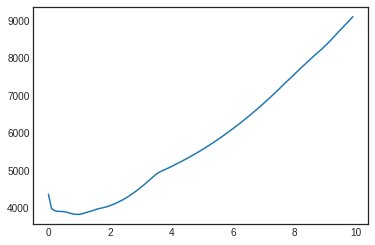

In [139]:
sns.lineplot(x=lambdalist,y=CVn)

In [140]:
CVn = pd.DataFrame(CVn)
lambdalist = pd.DataFrame(lambdalist)
pd.concat([CVn,lambdalist],axis=1)
#the MSE is minimised at alpha = 1, which implies that lambda = 0.901

,0,0
0,4364.660580,0.001
1,3981.941359,0.101
2,3927.352941,0.201
3,3906.380523,0.301
4,3904.453208,0.401
...,...,...
95,8751.832999,9.501
96,8837.310061,9.601
97,8923.539941,9.701
98,9010.886489,9.801


$ii.$

In [141]:
X = df4
y = df["Balance"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

clf = Lasso(alpha=0.901,fit_intercept=False,normalize=False,max_iter=5000)
lassomodel = clf.fit(X_train,y_train)
lassomodel.coef_

colnameslist = df4.columns.tolist()
coefficientlist = lassomodel.coef_.tolist()

dictionary = dict(zip(colnameslist, coefficientlist))
output = pd.DataFrame.from_dict(dictionary,orient='index')
output = output.rename(columns={0:"Coef"})
pd.set_option('display.max_rows', 200)
max_abs_diff = 0.00001
output

,Coef
Income,-280.796847
Limit,547.533418
Rating,59.013250
Cards,17.668327
Age,-10.845343
Education,-2.083350
Student,337.402461
Married,-0.000000
Asian,3.916612
African American,-0.000000


$iii.$

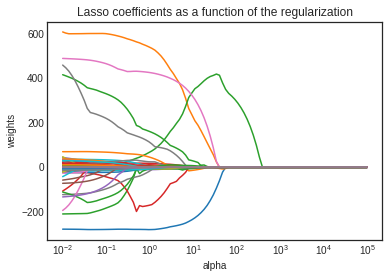

In [142]:
alphas = 10**np.linspace(5,-2,100)*0.5
lasso = Lasso(max_iter=100000)
coefs = []

for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');
plt.rcParams["figure.figsize"] = (10,10)

$iv.$

In [143]:
#Out of Sample
OOS = (pd.DataFrame.from_dict({'Income':100,'Limit':6000,'Rating':500,'Cards':3,'Age':70,'Education':12,'Student':0,'Married':1,'Asian':1,'African American':0,'Male':0},orient='index')).T

# $Question\;(2)$

# $(a)$

In [144]:
# dummy variables
#credit = pd.read_csv('Credit.csv')
#credit.dropna()
#credit.drop("ID",axis=1,inplace=True)
#credit['Female'] = credit.Gender.map({' Male':0, 'Female':1})
#credit['Student'] = credit.Student.map({'No':0, 'Yes':1})
#credit['Married'] = credit.Married.map({'No':0, 'Yes':1})
##Dummy for Ethnicity
#credit.loc[:,"Asian"] = [1 if x=="Asian" else 0 for x in credit["Ethnicity"]]
#credit.loc[:,"African American"] = [1 if x=="African American" else 0 for x in credit["Ethnicity"]]
#credit.drop(columns="Ethnicity",inplace=True)
#credit.info()

In [145]:
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

In [146]:
df = pd.read_csv("Credit.csv")

#student, married, ethnicity

#Create dummies for:  
df.drop("ID",axis=1,inplace=True)
df.dropna()

#Dummy for Student
df.loc[:,"Student"] = [1 if x=="Yes" else 0 for x in df["Student"]]

#Dummy for Married
df.loc[:,"Married"] = [1 if x=="Yes" else 0 for x in df["Married"]]

#Dummy for Ethnicity
df.loc[:,"Asian"] = [1 if x=="Asian" else 0 for x in df["Ethnicity"]]
df.loc[:,"African American"] = [1 if x=="African American" else 0 for x in df["Ethnicity"]]
df.drop(columns="Ethnicity",inplace=True)

#Dummy for Gender
df.loc[:,"Male"] = [1 if x=="Male" else 0 for x in df["Gender"]]
df.drop(columns="Gender",inplace=True)

X = df.drop('Balance', axis=1)
y = df.Balance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [147]:
# the tree regression
regr = DecisionTreeRegressor(max_depth=3,)
regr.fit(X_train, y_train)
pred = regr.predict(X_test)

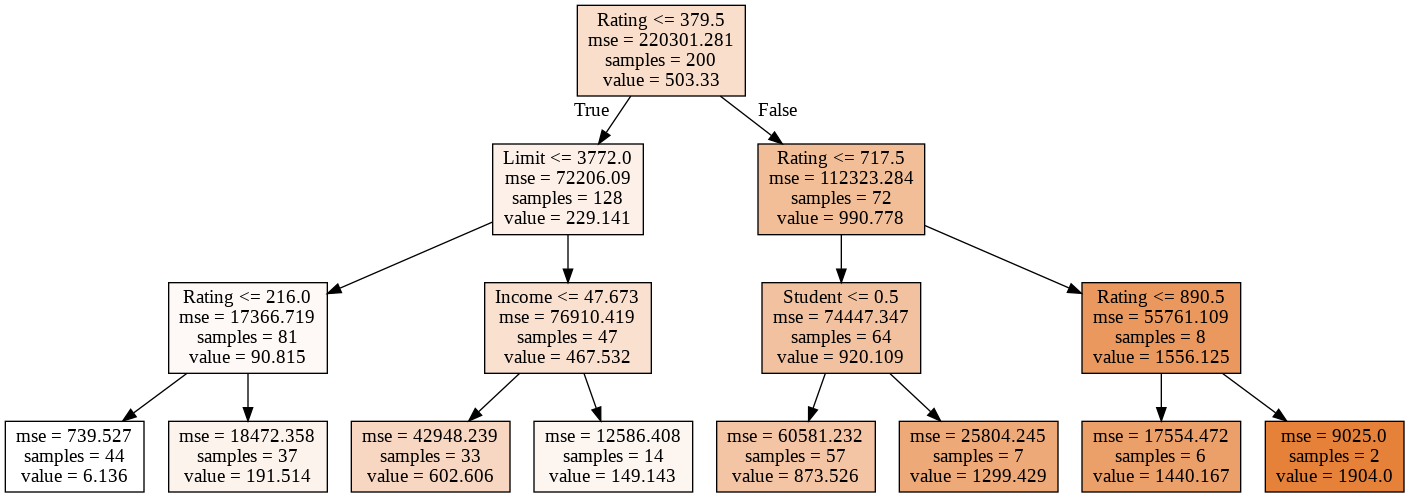

In [148]:
# visualize the tree
graph, = print_tree(regr, features=X.columns)
Image(graph.create_png())

The source node at the top implies that rating is the most important variable in determining an individuals debt balance. The right hand side branches into assigning those with higher levels of debt and the left hand side less so. It also shows that being a student has a strong impact on the predicted balance of the individual. On the other hand income also plays a larger role on the left hand side branch which assigns those on a lower level of income to a higher level of debt, which is a plausible conclusion to draw.
The issue with this tree however, is that with such a range of possible balances, there are so few terminal nodes, which consequently causes a very large MSE.


# $(b)$

In [149]:
#CV for Test MSE
abs(cross_val_score(regr, X, y, cv=5, scoring='neg_mean_squared_error').mean())

52043.713781530685

# $(c)$

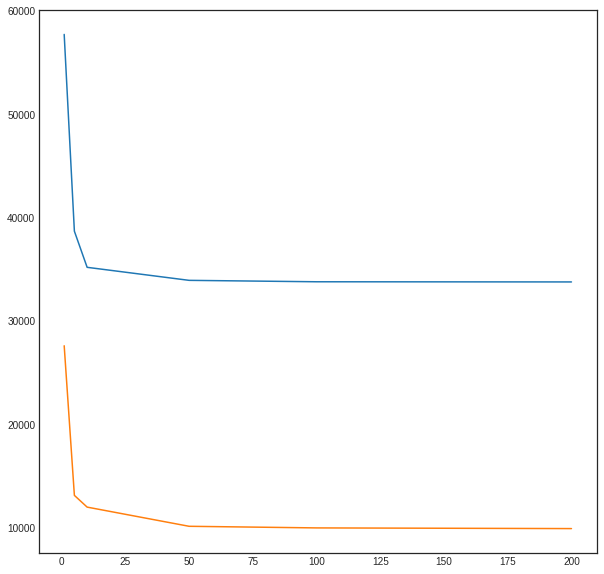

In [150]:
trees = [1, 5, 10, 50, 100, 200]
testmse_3depth = []


for i in trees:
  randomforest = RandomForestRegressor(n_estimators=i,max_depth=3, random_state=0)
  testmse_3depth.append(abs(cross_val_score(randomforest, X, y, cv=5, scoring='neg_mean_squared_error').mean()))

testmse_muchdepth = []
for i in trees:
  randomforest = RandomForestRegressor(n_estimators=i, random_state=0)
  testmse_muchdepth.append(abs(cross_val_score(randomforest, X, y, cv=5, scoring='neg_mean_squared_error').mean()))

sns.lineplot(x=trees,y=testmse_3depth)
sns.lineplot(x=trees,y=testmse_muchdepth)

The clearest finding from the plot above is that using the forest which does not limit the depth results in a far more reduced test MSE, this is because there is more flexibility in capturing information about the input data and subsequent predictions are then likely to yield more accurate results. Although it is important that we do not go too deep and end up overfitting the data. That would not be ideal.

# $(d)$

From the prior section, using the 50 tree random forest on the unrestricted depth yields the lowest test MSE using the 5 fold CV, since it is almost identical in test MSE to those with a larger number of trees it may be better to use a more parsimonious model to perform the out of sample prediction.

In [151]:
#Out of sample obs
OOS

,Income,Limit,Rating,Cards,Age,Education,Student,Married,Asian,African American,Male
0,100,6000,500,3,70,12,0,1,1,0,0


In [152]:
rf50 = RandomForestRegressor(n_estimators=50, random_state=0)
prediction = rf50.fit(X_train,y_train).predict(OOS)
prediction

array([807.92])

The prediction for the stated individual would have an outstanding debt balance of around 808.

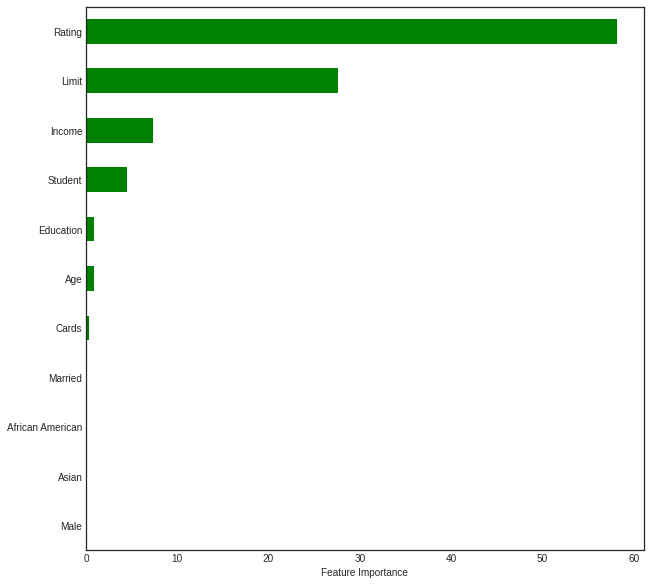

In [153]:
importances = rf50.feature_importances_*100

imp = pd.Series(importances,index=X.columns.tolist()).sort_values(inplace=False)
imp.T.plot(kind='barh', color='g', figsize=(10,10))

plt.xlabel('Feature Importance')
plt.gca().legend_ = None

Again we see that using a random forest rating plays the most important role in determining the balance of an individual, which is closely followed by limit and income, this follows quite closely with the very first tree seen in part (a).